## Introduction: 

In solving  this  data-driven problem, the  below  tasks  will be covered:- 

1. Load the dataset in the notebook using Pandas. 
2. Perform Exploratory Data  Analysis (EDA). This  includes plots  related to:-

    a) Total daily, weekly and monthly sales volumes.
    
    b) Last months’ revenue share by product and by customer.
    
    c) Weighted average monthly sale price by volume

3. Data Cleaning and  Encoding if need be.

4. Data  Modelling in relation to time series-based revenue prediction. 

### Dataset:

The  experiments that follow a UK-based and registered non-store (online) transactional data set. The  timespan covered in the dataset is between  01/12/2009 and 09/12/2011. The  company sells unique all-occasion gift-ware and wholesalers  make up a high number of their customers. More details on the dataset in CSV format are here: https://www.kaggle.com/mashlyn/online-retail-ii-uci#



In [1]:
#%matplotlib inline
#Import packages for the  task. Each package has its job
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as  np # linear algebra
import random as rd # generating random numbers
import datetime # manipulating date formats

# Visualizations package 
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots
import chart_studio.plotly as py
pd.set_option('display.max_columns', 100)
import plotly.offline as pyoff
import plotly.graph_objs as go

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
pd.options.display.max_columns = 30

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

### Ingest the  dataset

In [2]:
sales_data = pd.read_csv("online_retail_II.csv") #Read the data as a pandas dataframe

In [3]:
sales_data.head() #Visualize the top 5 records  of the dataframe  

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Exploratory Data Analysis 

### 1. Extract Time  Specific information 
This entails extraction of week, day, month and year fields from the datefield  for easier grouping of  transactional data. 

In [4]:
sales_data.info() #Summarizes the datatypes for different  attributes. Better view of  what data types need to be changed if need be.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [5]:
sales_data = sales_data.rename(columns={"Customer ID": "CustomerID"})
sales_data['InvoiceDate'] = pd.to_datetime(sales_data['InvoiceDate'])

In [6]:
sales_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [28]:
#New attributes are  introduced in the dataframe.
sales_data['InvoiceYearMonth'] = sales_data['InvoiceDate'].map(lambda date: 100*date.year + date.month)
sales_data['InvoiceYearWeek'] = sales_data['InvoiceDate'].map(lambda date: 100*date.year + date.week)
sales_data['InvoiceYearDay'] = sales_data['InvoiceDate'].map(lambda date: 100*date.year + date.day)
sales_data['day_of_year']= pd.DatetimeIndex(sales_data['InvoiceDate']).dayofyear 
sales_data['Date']= pd.DatetimeIndex(sales_data['InvoiceDate']).date

In [15]:
sales_data['week_of_year']= pd.DatetimeIndex(sales_data['Date']).week
sales_data['InvoiceYearMonthDay'] = sales_data['InvoiceYearMonth'].astype(str) + sales_data['day_of_year'].astype(str)

In [8]:
#Compute revenue per transaction i.e. price times quantity
sales_data['Revenue'] = sales_data['Quantity'] * sales_data['Price'] 

In [46]:
sales_data.tail(5) 

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,InvoiceYearMonth,InvoiceYearWeek,InvoiceYearDay,InvoiceYearMonthDay,Revenue,day_of_year,Date
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,201112,201149,201109,201112343,12.60,343,2011-12-09
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,201112,201149,201109,201112343,16.60,343,2011-12-09
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,201112,201149,201109,201112343,16.60,343,2011-12-09
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,201112,201149,201109,201112343,14.85,343,2011-12-09
1067370,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.00,12680.0,France,201112,201149,201109,201112343,18.00,343,2011-12-09


In [33]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 15 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Invoice              1067371 non-null  object        
 1   StockCode            1067371 non-null  object        
 2   Description          1062989 non-null  object        
 3   Quantity             1067371 non-null  int64         
 4   InvoiceDate          1067371 non-null  datetime64[ns]
 5   Price                1067371 non-null  float64       
 6   CustomerID           824364 non-null   float64       
 7   Country              1067371 non-null  object        
 8   InvoiceYearMonth     1067371 non-null  int64         
 9   InvoiceYearWeek      1067371 non-null  int64         
 10  InvoiceYearDay       1067371 non-null  int64         
 11  InvoiceYearMonthDay  1067371 non-null  object        
 12  Revenue              1067371 non-null  float64       
 1

#### Check for  Null values if any exist

In [36]:
sales_data.isnull().sum().sort_values(ascending=False) ## Get the  NaNs. Customer ID and  Description have  mising  values.
#Not  relevant for the time  series so can  be left that way

CustomerID             243007
Description              4382
Date                        0
day_of_year                 0
Revenue                     0
InvoiceYearMonthDay         0
InvoiceYearDay              0
InvoiceYearWeek             0
InvoiceYearMonth            0
Country                     0
Price                       0
InvoiceDate                 0
Quantity                    0
StockCode                   0
Invoice                     0
dtype: int64

### 2. Daily, Weekly, Monthly  Sales 
#### a) Daily

In [34]:
daily_data_revenue = sales_data.groupby(['Date'])['Revenue'].sum().reset_index()

In [35]:
daily_sales_plot_data = [
    go.Scatter(
        x=daily_data_revenue['Date'],
        y=daily_data_revenue['Revenue'],
    )
]
plot_layout_daily_sales  = go.Layout(
        xaxis={"type": "category"},
        title='Sales/Day between 01/12/2009 and 09/12/2011. Format for the date is YYYYMMDD' )
#Plot  daily data
fig_daily_sales = go.Figure(data=daily_sales_plot_data, layout=plot_layout_daily_sales)
pyoff.iplot(fig_daily_sales)

In [39]:
min(daily_data_revenue["Revenue"])

-22212.609000000026

#### b) Weekly

In [47]:

weekly_data_revenue = sales_data.groupby(['InvoiceYearWeek'])['Revenue'].sum().reset_index()

In [49]:
weekly_sales_plot_data = [
    go.Scatter(
        x=weekly_data_revenue['InvoiceYearWeek'],
        y=weekly_data_revenue['Revenue'],
    )
]
plot_layout_weekly_sales  = go.Layout(
        xaxis={"type": "category"},
        title='Sales/Week between 01/12/2009 and 09/12/2011 -Format is YearWeek (YYYYWW)' )

#Plot weekly sales data
fig_weekly_sales = go.Figure(data=weekly_sales_plot_data, layout=plot_layout_weekly_sales)
pyoff.iplot(fig_weekly_sales)


In [51]:
max(weekly_data_revenue["Revenue"])

498289.55000001454

#### c) Monthly

In [54]:
monthly_revenue = sales_data.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()

In [55]:
monthly_sales_plot_data = [
    go.Scatter(
        x=monthly_revenue['InvoiceYearMonth'],
        y=monthly_revenue['Revenue'],
    )
]
plot_layout_monthly_sales  = go.Layout(
        xaxis={"type": "category"},
        title='Sales/Month between 01/12/2009 and 09/12/2011 -Format is YearMonth (YYYYMM)' )
#Plot  monthly sales
fig_monthly_sales = go.Figure(data=monthly_sales_plot_data, layout=plot_layout_monthly_sales)
pyoff.iplot(fig_monthly_sales)

In [56]:
min(monthly_data_revenue["Revenue"])

433686.0100000171

### Last months’ revenue share by : -
#### a) Product 

In [57]:
last_month_df = sales_data[sales_data["InvoiceYearMonth"] == 201112] #Data for the last month.Has -ve values as sales. Have to be removed

In [58]:
last_month_df = last_month_df[last_month_df["Revenue"]> 0]

In [59]:
len(last_month_df) #25112 transactions  in the last month (2011-12). Many to be  plotted

25112

In [60]:
last_month_df["Revenue"].sum()

638810.6799999999

In [61]:
last_month_revenue = last_month_df.groupby('StockCode')['Revenue'].sum().sort_values(ascending=False)

In [62]:
max(last_month_revenue)

168469.6

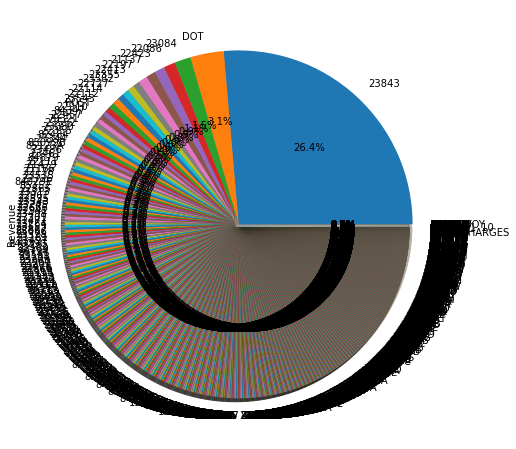

In [63]:
fig, axes = plt.subplots(figsize=(14,8))
quantity_plot= last_month_revenue.plot(kind='pie',subplots=True,legend=False, \
                   autopct='%1.1f%%',  \
                   shadow=True, startangle=0) #Output has 2470 unique products sold. Pie  chart below cant be rendered well. 


In [64]:
len(last_month_df["StockCode"].unique()) #There are 2494 unique  products sold  in 201112

2470

#### b) Customer

In [65]:
len(last_month_df["CustomerID"].unique()) #There are  616 customers  in the dataset in the  last month

616

In [66]:
last_month_revenue_per_customer = last_month_df.groupby('CustomerID')['Revenue'].sum().sort_values(ascending=False)

In [67]:
last_month_revenue_per_customer

CustomerID
16446.0    168469.60
16000.0     12393.70
14646.0     11728.02
18102.0     11485.54
14096.0      8935.98
             ...    
13079.0        30.00
15060.0        16.61
16103.0        16.50
16271.0        15.00
14865.0        15.00
Name: Revenue, Length: 615, dtype: float64

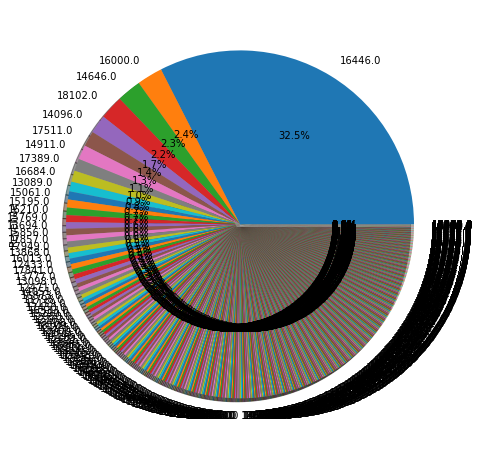

In [68]:
fig, axes = plt.subplots(figsize=(14,8))
quantity_plot_per_customer = last_month_revenue_per_customer.plot(kind='pie',subplots=True,legend=False, \
                   autopct='%1.1f%%',  \
                   shadow=True, startangle=0) #616 customers transacted in the last month. 

32.5% of  the revenue share  was generated by customer with ID = 16446

### Weighted average monthly sale price by volume
Weighted average unlike the conventional average  makes sense when it comes to revenue projections. Revenue based on the quantity purchased reflects  better on the purchasing patterns for customers thus  is given weight.

In [69]:
#Function to computer weighted  average
def wavg(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [70]:
sales_data.groupby("InvoiceYearMonth").apply(wavg, "Price", "Quantity")#average monthly sale price by quantity 

InvoiceYearMonth
200912    1.903999
201001    1.662478
201002    1.447037
201003    1.564969
201004    1.677924
201005    1.690006
201006    1.750886
201007    1.903489
201008    1.453679
201009    1.784901
201010    1.736942
201011    2.111215
201012    2.213595
201101    1.812498
201102    1.791663
201103    1.941806
201104    1.706021
201105    1.901553
201106    2.023058
201107    1.741939
201108    1.680655
201109    1.854595
201110    1.876678
201111    1.974583
201112    1.916133
dtype: float64

### 3. Filter Items with Negative Volumes 

In [71]:
len(sales_data[sales_data["Quantity"] < 1]) #There are 22950 sales transactions with negative quantities

22950

#### Samples of products with negative  quantities

In [72]:
sales_data[sales_data["Quantity"] < 1]  # 0 quantity is  included  as it doesnt add any value to the modelling  process

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,InvoiceYearMonth,InvoiceYearWeek,InvoiceYearDay,InvoiceYearMonthDay,Revenue,day_of_year,Date
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,200912,200949,200901,200912335,-35.40,335,2009-12-01
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia,200912,200949,200901,200912335,-9.90,335,2009-12-01
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia,200912,200949,200901,200912335,-17.00,335,2009-12-01
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia,200912,200949,200901,200912335,-12.60,335,2009-12-01
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,200912,200949,200901,200912335,-35.40,335,2009-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065910,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,201112,201149,201109,201112343,-9.13,343,2011-12-09
1067002,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,201112,201149,201109,201112343,-224.69,343,2011-12-09
1067176,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,201112,201149,201109,201112343,-54.75,343,2011-12-09
1067177,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,201112,201149,201109,201112343,-1.25,343,2011-12-09


In [73]:
new_sales_data = sales_data[sales_data["Quantity"] > 0] # Filter out transactions with sales volumes less than 1 

In [74]:
len(new_sales_data) #1044421 records with sold quantity greater than 1. 

1044421

new_sales_data is  the  df that will be  modelled further.

In [75]:
new_sales_data.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,InvoiceYearMonth,InvoiceYearWeek,InvoiceYearDay,InvoiceYearMonthDay,Revenue,day_of_year,Date
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,201112,201149,201109,201112343,12.60,343,2011-12-09
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,201112,201149,201109,201112343,16.60,343,2011-12-09
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,201112,201149,201109,201112343,16.60,343,2011-12-09
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,201112,201149,201109,201112343,14.85,343,2011-12-09
1067370,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.00,12680.0,France,201112,201149,201109,201112343,18.00,343,2011-12-09


In [76]:
new_sales_data["InvoiceDate"] =  new_sales_data['InvoiceDate'].dt.date

Suggestions to the  owner:- 

#### 1. What metrics/values you might want to use? 

- I would suggest using historical revenue values to forecast the revenue for the remaining days of the month. 

#### 2 .How you would aggregate those metrics?

- Revenue will be computed per day across the dataset. 

#### 3. What model/algorithm or logic you would use to make a prediction on them?

- I would look at a time series algorithm. ARIMA  and  Facebook's prophet are  probable algorithms.

#### 4. What uncertainties might need to be explored?
- Seasonality bearing  in mind sale at chrismas  times naturally deeps (buyers purchase early enough) or may be higher (most people are on holiday). They may need them as Christmas gifts. 
- Data  quality. A number of  records with negative  values were  filtered out. May affect the modelling results as ideally a few days are e filtered from the dataset.   



### Facebook's  Prophet 

Prophet works best with hourly and weekly data over several months. Yearly data  is most preferred according to Facebook Research:

At its core, the Prophet procedure is an additive regression model with four main components:

1. A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting change points from the data.
2. A yearly seasonal component modeled using Fourier series.
3. A weekly seasonal component using dummy variables.
4. A user-provided list of important holidays.

I'll look at this sales predictions as a Univariate Analysis. This  will be possible when daily sales data is aggregated and modelled. Predictions can then be  made on the same. 

In [77]:
from fbprophet import Prophet #import Facebooks  prophet

In [78]:
new_sales_data_grouped = new_sales_data.groupby(['InvoiceDate'])['Revenue'].sum().reset_index()

In [79]:
new_sales_data_grouped.head(5)  #Daily sales data 

,InvoiceDate,Revenue
0,2009-12-01,54513.50
1,2009-12-02,63352.51
2,2009-12-03,74037.91
3,2009-12-04,40732.92
4,2009-12-05,9803.05


Prophet expects the dataset to have two columns named as **ds** and **y**. **ds** is the date column while **y** is the column being forecasted  i.e. Revenue  

In [80]:
new_sales_data_grouped = new_sales_data_grouped.rename(columns={"InvoiceDate": "ds","Revenue":"y"})

In [81]:
new_sales_data_grouped.head()

,ds,y
0,2009-12-01,54513.50
1,2009-12-02,63352.51
2,2009-12-03,74037.91
3,2009-12-04,40732.92
4,2009-12-05,9803.05


In [82]:
len(new_sales_data_grouped)

604

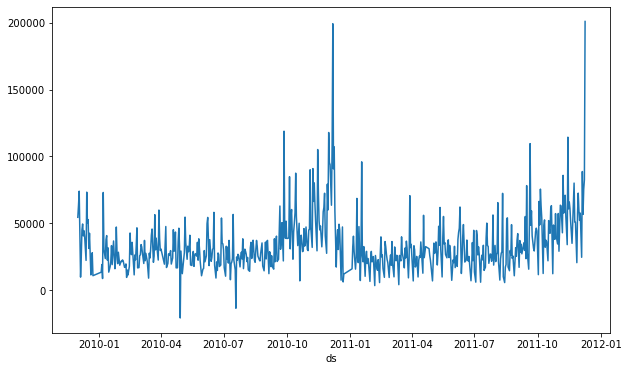

In [83]:
new_sales_data_grouped.set_index('ds').y.plot()

A few negative  values that need to be removed. I deally zero should  be  the value if  nothing was sold.

In [84]:
new_sales_data_grouped = new_sales_data_grouped[new_sales_data_grouped["y"] > 0] #Remove  negatives again as ideally was removed initially

In [85]:
len(new_sales_data_grouped) # Two records with negatives were removed. We model 602 of them 

602

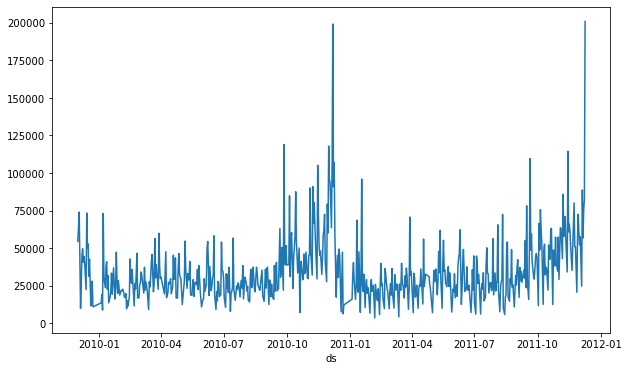

In [86]:
new_sales_data_grouped.set_index('ds').y.plot()

Negatives records have been filtered out of the database.

In [87]:
df = new_sales_data_grouped.copy() #Create a copy of the dataframe in case of  any alterations to the  original one.  

### Model Fitting
Create an instance of the Prophet class and then fit it the dataset. 

Note: I added UK holidays  to be  part of the model. Holidays may influence buying  behaviour. 

In [89]:
prophet_model = Prophet()
prophet_model.add_country_holidays(country_name='UK')
prophet_model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [90]:
future_period = prophet_model.make_future_dataframe(periods=30, freq ='d') 
future_period.tail()


,ds
627,2012-01-04
628,2012-01-05
629,2012-01-06
630,2012-01-07
631,2012-01-08


Last date with sales is  2011-12-09. I'm interested in predicting to the end of the month. 
That way'll be e able to tell whether the owner is  able to get a Ferarri by Xmas time 

### Forecasting  
**predict** method to make future predictions. This generates a df with a **yhat** column that will contain the predictions.


In [91]:
forecasts = prophet_model.predict(future_period)

The resulting forecast dataframe has quite some attributes. Sample of the dataframe is below.

In [94]:
forecasts.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Battle of the Boyne [Northern Ireland],Battle of the Boyne [Northern Ireland]_lower,Battle of the Boyne [Northern Ireland]_upper,Boxing Day,Boxing Day_lower,Boxing Day_upper,Boxing Day (Observed),Boxing Day (Observed)_lower,Boxing Day (Observed)_upper,...,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
602,2011-12-10,27620.057280,-8050.904749,30558.346627,27620.057280,27620.057280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-15835.596258,-15835.596258,0.0,0.0,0.0,-46418.892170,-46418.892170,-46418.892170,30583.295912,30583.295912,30583.295912,0.0,0.0,0.0,11784.461022
603,2011-12-11,27623.741174,29969.938268,66917.733423,27623.741174,27623.741174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20323.689551,20323.689551,0.0,0.0,0.0,-8184.649088,-8184.649088,-8184.649088,28508.338639,28508.338639,28508.338639,0.0,0.0,0.0,47947.430724
604,2011-12-12,27627.425067,47509.270588,83600.217108,27627.425067,27627.425067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37993.059380,37993.059380,0.0,0.0,0.0,11818.966986,11818.966986,11818.966986,26174.092394,26174.092394,26174.092394,0.0,0.0,0.0,65620.484448
605,2011-12-13,27631.108961,44684.666581,83204.988823,27631.108961,27631.108961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37146.102408,37146.102408,0.0,0.0,0.0,13538.573583,13538.573583,13538.573583,23607.528824,23607.528824,23607.528824,0.0,0.0,0.0,64777.211369
606,2011-12-14,27634.792855,36176.796398,74348.047384,27634.792855,27634.792855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28371.720995,28371.720995,0.0,0.0,0.0,7530.587773,7530.587773,7530.587773,20841.133222,20841.133222,20841.133222,0.0,0.0,0.0,56006.513850
607,2011-12-15,27638.476749,42571.011482,80397.130802,27638.476749,27638.476749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32881.608519,32881.608519,0.0,0.0,0.0,14969.340413,14969.340413,14969.340413,17912.268106,17912.268106,17912.268106,0.0,0.0,0.0,60520.085268
608,2011-12-16,27642.160643,30769.425061,68743.373428,27642.123669,27642.934387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21608.474484,21608.474484,0.0,0.0,0.0,6746.072503,6746.072503,6746.072503,14862.401982,14862.401982,14862.401982,0.0,0.0,0.0,49250.635127
609,2011-12-17,27645.844536,-26514.355512,12753.372989,27644.566580,27647.955698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-34682.670252,-34682.670252,0.0,0.0,0.0,-46418.892170,-46418.892170,-46418.892170,11736.221918,11736.221918,11736.221918,0.0,0.0,0.0,-7036.825715
610,2011-12-18,27649.528430,8673.477887,45920.094682,27646.398362,27653.884727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,396.002839,396.002839,0.0,0.0,0.0,-8184.649088,-8184.649088,-8184.649088,8580.651927,8580.651927,8580.651927,0.0,0.0,0.0,28045.531270
611,2011-12-19,27653.212324,26147.388464,66076.452446,27648.111652,27659.426648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17262.768847,17262.768847,0.0,0.0,0.0,11818.966986,11818.966986,11818.966986,5443.801861,5443.801861,5443.801861,0.0,0.0,0.0,44915.981171


yhat, yhat_lower and yhat_upper are the important  ones. 

In [128]:
forecasts[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
602,2011-12-10,11784.461022,-8050.904749,30558.346627
603,2011-12-11,47947.430724,29969.938268,66917.733423
604,2011-12-12,65620.484448,47509.270588,83600.217108
605,2011-12-13,64777.211369,44684.666581,83204.988823
606,2011-12-14,56006.513850,36176.796398,74348.047384
607,2011-12-15,60520.085268,42571.011482,80397.130802
608,2011-12-16,49250.635127,30769.425061,68743.373428
609,2011-12-17,-7036.825715,-26514.355512,12753.372989
610,2011-12-18,28045.531270,8673.477887,45920.094682
611,2011-12-19,44915.981171,26147.388464,66076.452446


In [96]:
forecasts[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2009-12-01,68106.917856,47509.148084,86866.226778
1,2009-12-02,62521.873838,44220.549357,82139.827556
2,2009-12-03,70143.267972,51343.856577,89482.708329
3,2009-12-04,61839.163178,42857.638431,81932.001841
4,2009-12-05,8311.251310,-10663.875957,28280.450398


#### Plotting Prophet results
Prophet has a plotting method called plot. This plot functionality draws the original data (black dots), the model (blue line) and the error of the forecast (shaded blue area).

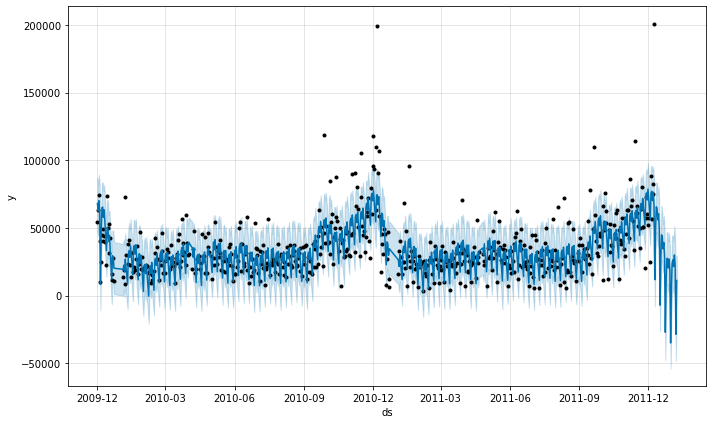

In [102]:
forecasts_plot = prophet_model.plot(forecasts)

#### Plotting the Forecast Components

This component plot is an important plot as it lets you see the components of your model including the trend and seasonality.

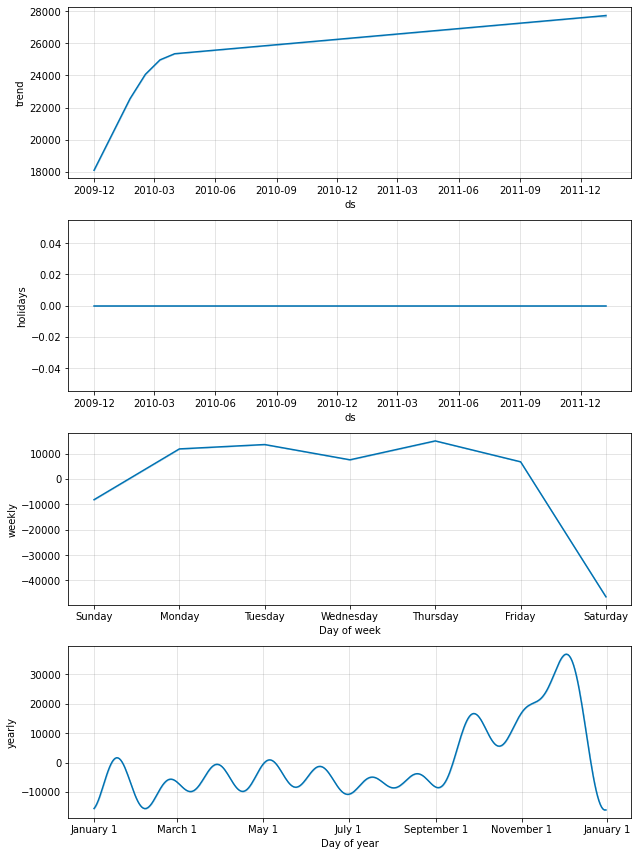

In [103]:
forecast_components = prophet_model.plot_components(forecasts)

Holiday didnt  need to be there. Could  be  excluded.

### Accuracy

Important  to look at how  the predicted revenue compares to the actual values.  R-Squared and Mean Squared Error (MSE) metrics are used.

To do this, we need to build a combined dataframe with yhat from the forecasts and the original 'y' values from the data.

In [104]:
df_metrics  = forecasts.set_index('ds')[['yhat']].join(df.set_index('ds').y).reset_index()

In [107]:
df_metrics.tail()

,ds,yhat,y
627,2012-01-04,21458.335234,NaN
628,2012-01-05,30076.744631,NaN
629,2012-01-06,23187.473849,NaN
630,2012-01-07,-28532.602969,NaN
631,2012-01-08,11212.586026,NaN


"NaNs" are in the last part of  "y" column. We can remove  them as  the concern is with  actual and forecasted values.

In [108]:
df_metrics.dropna(inplace=True)

In [109]:
df_metrics.tail()

,ds,yhat,y
597,2011-12-05,75978.989916,88741.96
598,2011-12-06,77110.402215,56713.21
599,2011-12-07,70214.109687,75439.16
600,2011-12-08,76459.815470,82495.00
601,2011-12-09,66740.438877,200938.60


#### R-Squared Value
R-Squared is a statistical measure of fit that indicates how much variation of a dependent variable is explained by the independent variable(s) in a regression model. R-squared values range from 0 to 1 and are commonly stated as percentages from 0% to 100%. An R-squared of 100% means that all movements another dependent variable are completely explained by movements in the index (or the independent variable(s) you are interested in).



In [111]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
r2_score(df_metrics.y, df_metrics.yhat)

0.5117102443144212

Values between 0.85 and  1.0 are considered  great in explaining the  interdependence between the variables in quetion. 0.5 is  not a good value in the interdependence aspect. Sometimes  a very high value would  mean an overfit model.

#### Mean Squared Error (MSE)
The mean squared error tells you how close a regression line is to a set of points. It does this by taking the distances from the points to the regression line (these distances are the “errors”) and squaring them. The squaring is necessary to remove any negative signs. It also gives more weight to larger differences. It’s called the mean squared error as you’re finding the average of a set of errors.
https://www.statisticshowto.com/mean-squared-error/

In [113]:
mean_squared_error(df_metrics.y, df_metrics.yhat)

219906550.25463057

MSE value close to 0 is ideal. The above is such a large number as much as the  model doesnt  seem overfit as with the R-Squared Value 

#### Mean Absolute Error (MAE)
It is a measure of errors between paired observations expressing the same phenomenon. Examples of Y versus X include comparisons of predicted versus observed, subsequent time versus initial time, and one technique of measurement versus an alternative technique of measurement.

In [114]:
mean_absolute_error(df_metrics.y, df_metrics.yhat)

9784.14832450039

The output is not  so great. What that tells me is that for each data point, my average magnitude of error is roughly 9784GBP which is  not  so great. MAE values range from 0 to ∞ and are indifferent to the direction of errors. They are negatively-oriented scores, which means lower values are better. Removal of the negative records may be some of the reasons  for this.

#### Lets  see whether the owner will get the Ferrari for Christmas

In [144]:
forecasts[['ds', 'yhat']].tail(30)

,ds,yhat
602,2011-12-10,11784.461022
603,2011-12-11,47947.430724
604,2011-12-12,65620.484448
605,2011-12-13,64777.211369
606,2011-12-14,56006.513850
607,2011-12-15,60520.085268
608,2011-12-16,49250.635127
609,2011-12-17,-7036.825715
610,2011-12-18,28045.531270
611,2011-12-19,44915.981171


In [137]:
forecasts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632 entries, 0 to 631
Data columns (total 76 columns):
 #   Column                                                             Non-Null Count  Dtype         
---  ------                                                             --------------  -----         
 0   ds                                                                 632 non-null    datetime64[ns]
 1   trend                                                              632 non-null    float64       
 2   yhat_lower                                                         632 non-null    float64       
 3   yhat_upper                                                         632 non-null    float64       
 4   trend_lower                                                        632 non-null    float64       
 5   trend_upper                                                        632 non-null    float64       
 6   Battle of the Boyne [Northern Ireland]                            

In [140]:
df_forecasts_last_month.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Battle of the Boyne [Northern Ireland],Battle of the Boyne [Northern Ireland]_lower,Battle of the Boyne [Northern Ireland]_upper,Boxing Day,Boxing Day_lower,Boxing Day_upper,Boxing Day (Observed),Boxing Day (Observed)_lower,Boxing Day (Observed)_upper,...,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
619,2011-12-27,27682.683475,8881.252640,46811.925515,27657.752616,27709.430951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-131.157408,-131.157408,0.0,0.0,0.0,13538.573583,13538.573583,13538.573583,-13669.730992,-13669.730992,-13669.730992,0.0,0.0,0.0,27551.526066
620,2011-12-28,27686.367368,2195.450290,40220.253161,27657.440412,27717.077971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7273.771319,-7273.771319,0.0,0.0,0.0,7530.587773,7530.587773,7530.587773,-14804.359092,-14804.359092,-14804.359092,0.0,0.0,0.0,20412.596049
621,2011-12-29,27690.051262,6757.869038,46263.981679,27658.258628,27723.933596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-630.420081,-630.420081,0.0,0.0,0.0,14969.340413,14969.340413,14969.340413,-15599.760494,-15599.760494,-15599.760494,0.0,0.0,0.0,27059.631181
622,2011-12-30,27693.735156,-1023.231528,36139.566475,27656.804537,27730.233991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-9310.698754,-9310.698754,0.0,0.0,0.0,6746.072503,6746.072503,6746.072503,-16056.771257,-16056.771257,-16056.771257,0.0,0.0,0.0,18383.036402
623,2011-12-31,27697.419050,-53836.873910,-15029.907397,27656.440123,27738.051683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-62602.366086,-62602.366086,0.0,0.0,0.0,-46418.892170,-46418.892170,-46418.892170,-16183.473916,-16183.473916,-16183.473916,0.0,0.0,0.0,-34904.947036


In [145]:
df.tail(10)

,ds,y
594,2011-11-29,72595.93
595,2011-11-30,60126.96
596,2011-12-01,52197.25
597,2011-12-02,57664.07
598,2011-12-04,24621.43
599,2011-12-05,88741.96
600,2011-12-06,56713.21
601,2011-12-07,75439.16
602,2011-12-08,82495.00
603,2011-12-09,200938.60


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 602 entries, 0 to 603
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      602 non-null    object 
 1   y       602 non-null    float64
dtypes: float64(1), object(1)
memory usage: 14.1+ KB


In [150]:
df["ds"] = pd.to_datetime(df["ds"])

In [151]:
df_minus_forecast_last_month = df[(df['ds'] >= '2011-12-01') & (df['ds'] <= '2011-12-09')] # Help compute revenue between the dates  

In [157]:
sum(df_minus_forecast_last_month["y"])

638810.6799999999

In [153]:
df_forecasts_last_month  = forecasts[(forecasts['ds'] >= '2011-12-10') & (forecasts['ds'] <= '2011-12-31')] #Group all the records for the month

In [154]:
sum(df_forecasts_last_month["yhat"])

635499.2052492145

In [156]:
Total = sum(df_minus_forecast_last_month["y"]) + sum(df_forecasts_last_month["yhat"])
print(Total)

1274309.8852492145


As per the  model, the owner is  bound  to make revenue of  1274309.8852492145. According to the website https://www.supercars.net/blog/all-brands/ferrari/current-ferrari-models/, a 2020 Ferrari 812 Superfast Ferrari  goes for US$340,712 which is  equivalent to 258,079.12 British Pounds.  Revenue for the month is  1274309.88. According to acceptable accounting standards, a 10 - 20% value of  the  revenue should be  the profits i.e. cost of  goods and administration. Therefore, the expected estimation is  a profit of  about  127430.9 to 254,861.8 GBP. In addition, the modelling issues explained below  advance  the  idea that the  model may not  be  very reliable. With these reasons, I would advise the owner not to promise the Ferrari. High chance that the money may not be sufficient  especially if  the busines is to be  kept afloat. 


### Other ways  of  extracting metrics

### Cross Validation
Measure the forecast error using the historical data. In order to perform this operation, we select cut off points in the data history and fit the model with data up to that cut off point.

Afterwards, we compare the actual values to the predicted values. The cross_validation method allows us to do this in Prophet. This method takes the following parameters, as explained below:
1. **horizon** the forecast horizon
2. **initial** the size of the initial training period
3. **period** the spacing between cutoff dates

The output of the cross_validation method is a dataframe containing y (the true values) and yhat (the predicted values). We’ll use this dataframe to compute the prediction errors.

In [115]:
len(new_sales_data_grouped) #Number of  days in the  training set

602

In [117]:
from fbprophet.diagnostics import cross_validation
cv_df = cross_validation(prophet_model, initial='604 days', period='30 days', horizon = '30 days')
cv_df.head()

INFO:fbprophet:Making 4 forecasts with cutoffs between 2011-08-11 00:00:00 and 2011-11-09 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-08-12,29615.641655,13331.629521,48405.020794,10107.23,2011-08-11
1,2011-08-14,18317.558255,871.562064,35716.408311,5718.57,2011-08-11
2,2011-08-15,36555.473419,19338.459654,54218.161033,17243.97,2011-08-11
3,2011-08-16,39566.818521,22346.821555,56332.100203,19239.66,2011-08-11
4,2011-08-17,32289.611917,14215.747541,50045.305265,53499.96,2011-08-11


### Performance Metrics

We use the *performance_metrics* utility to compute the **Mean Squared Error(MSE), Root Mean Squared Error(RMSE), Mean Absolute Error(MAE), Mean Absolute Percentage Error(MAPE)** and the coverage of the *yhat_lower* and *yhat_upper* estimates.

In [118]:
from fbprophet.diagnostics import performance_metrics
performance_metrics_df = performance_metrics(cv_df)
performance_metrics_df.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,1.733748e+08,13167.186106,11064.839174,0.609064,0.356812,0.700
1,4 days,1.430749e+08,11961.390893,10541.019645,0.538312,0.349933,0.800
2,5 days,5.671366e+08,23814.629390,19638.117166,0.681196,0.424440,0.500
3,6 days,5.406360e+08,23251.580873,18010.903018,0.443082,0.389545,0.525
4,7 days,5.225076e+08,22858.425094,17229.115528,0.342650,0.281977,0.600


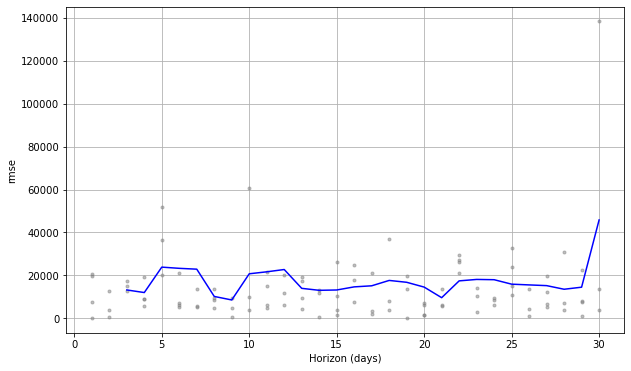

In [119]:
from fbprophet.plot import plot_cross_validation_metric
viz = plot_cross_validation_metric(cv_df, metric='rmse')

The rest will be completed  in future as I look into the errors based on the metrics above.

### AutoRegressive Integrated Moving Average (ARIMA) Model 
A time series can be broken down into 3 components.

1. Trend: Upward & downward movement of the data with time over a large period of time (i.e. house appreciation)
2. Seasonality: Seasonal variance (i.e. an increase in demand for ice cream during summer)
3. Noise: Spikes & troughs at random intervals

Before applying  the  statistical measure, we have to be certain that the series is stationary. Means  it should not be  a function of  time i.e. mean values increasing  over time. 


In [120]:
df_arima  = pd.read_csv("tofit.csv", parse_dates = ["ds"], infer_datetime_format=True, index_col = ["ds"])

In [121]:
df_arima = df_arima.drop(['Unnamed: 0'], axis=1)

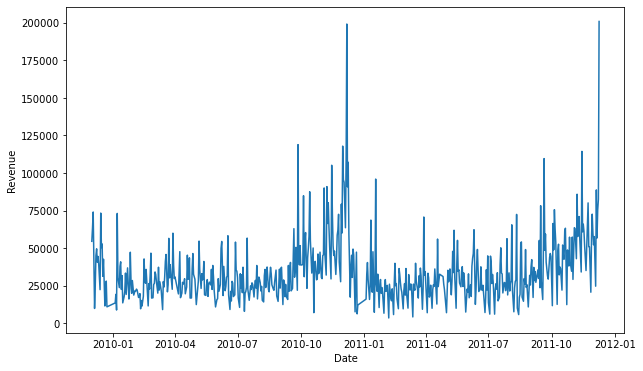

In [122]:
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.plot(df_arima)

In [123]:
df_arima.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 602 entries, 2009-12-01 to 2011-12-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       602 non-null    float64
dtypes: float64(1)
memory usage: 9.4 KB


### Determine whether the Series is  Stationary. 
1. **Rolling Statistics:** Plot the rolling mean and rolling standard deviation. The time series is stationary if they remain constant with time (with the naked eye look to see if the lines are straight and parallel to the x-axis).
2. **Augmented Dickey-Fuller Test:** The time series is considered stationary if the p-value is low (according to the null hypothesis) and the critical values at 1%, 5%, 10% confidence intervals are as close as possible to the ADF Statistics

#### Rolling Mean:


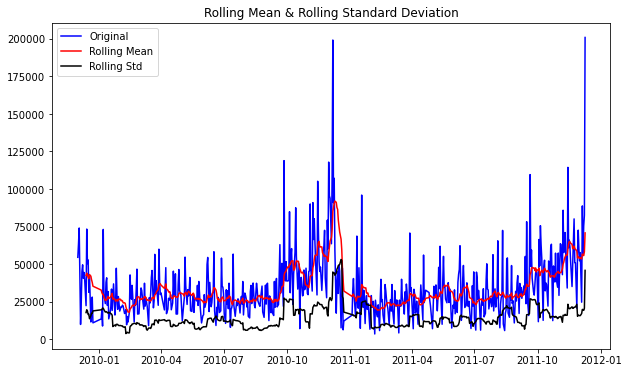

In [124]:
rolling_mean = df_arima.rolling(window = 12).mean()
rolling_std = df_arima.rolling(window = 12).std()
plt.plot(df_arima, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [125]:
result = adfuller(df_arima['y'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.4533077926841496
p-value: 0.5564700403293101
Critical Values:
	1%: -3.4415970480373046
	5%: -2.866501759246704
	10%: -2.5694124827594296


The ADF statistic  is  not far from critical values. The  graph means  and standard deviations seem stationary thus we can assume is  a stationary series, thus can go ahead and model. 

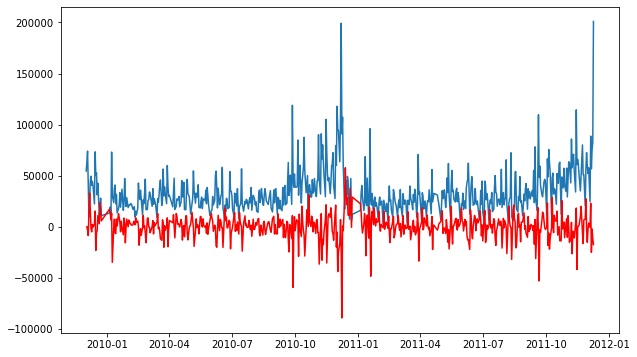

In [126]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_arima,freq = 52) 
model = ARIMA(df_arima, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_arima)
plt.plot(results.fittedvalues, color='red')

There is somehow  a big  difference  between the original and fitted values corroborating  the results with Prophet. To dos:-
    
    1. Re-look keenly at the data. High chance  there are missing days, making it  hard to model it daily. 
    
    2. Transformation of the data. Probably use the log of  current revenue  etc for better modelling. 
    